In [70]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import xgboost as xgb


### EDA - PyAFAR AU

In [3]:
pyafar_inf_filename = '../data/AU/pyafar_infants.csv'

pyafar_inf_df = pd.read_csv(pyafar_inf_filename)

In [46]:
affect_map = {3: "Pos", 1: "Neg", 2: "Neu"}
au_columns = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20', 'AU28']
custom_palette = {3: "#2ca02c", 1: "#d62728", 2: "#7f7f7f"}
custom_palette_string = { "3": "#2ca02c", "1": "#d62728", "2": "#7f7f7f"}


In [43]:
# Select relevant columns (imageID, Image, imageCat, and action units)
au_columns = ['Occ_au_1', 'Occ_au_2', 'Occ_au_3', 'Occ_au_4', 'Occ_au_6', 'Occ_au_9', 'Occ_au_12', 'Occ_au_20', 'Occ_au_28']
df_pyafar = pyafar_inf_df[['imageID', 'Image'] + au_columns + ['imageCat']]
df_pyafar["imageCat"] = df_pyafar["imageCat"].astype(int)

# Rename the action units columns
df_pyafar = df_pyafar.rename(columns={col: f"AU{col.split('_')[-1]}" for col in au_columns})
df_pyafar = df_pyafar[['imageID', 'Image'] + [f"AU{col.split('_')[-1]}" for col in au_columns] + ['imageCat']]

df_pyafar.head()


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_1684/4168424596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pyafar["imageCat"] = df_pyafar["imageCat"].astype(int)


,imageID,Image,AU1,AU2,AU3,AU4,AU6,AU9,AU12,AU20,AU28,imageCat
0,1,B1NegBW.bmp,0.582647,0.247536,0.199609,0.144951,0.749107,0.003546,0.262145,0.139866,0.054499,1
1,2,B1PosBw.bmp,0.630913,0.275316,0.029434,0.033410,0.921085,0.000916,0.968933,0.033123,0.257921,3
2,3,B2NegBw.bmp,0.501219,0.444231,0.948115,0.959741,0.999109,0.995002,0.920718,0.844951,0.002154,1
3,4,B2NeuBW.bmp,0.398275,0.739382,0.014437,0.011242,0.006104,0.000025,0.002992,0.002519,0.055800,2
4,6,B2PosBW.bmp,0.468657,0.641653,0.062889,0.042301,0.946381,0.005141,0.983136,0.750964,0.006738,3


In [44]:
# Summary statistics
print(df_pyafar.describe())

          imageID         AU1         AU2         AU3         AU4         AU6  \
count  151.000000  151.000000  151.000000  151.000000  151.000000  151.000000   
mean   131.350993    0.606039    0.459843    0.410515    0.303994    0.518270   
std     80.330584    0.275114    0.301231    0.373571    0.377383    0.427855   
min      1.000000   -1.000000   -1.000000   -1.000000   -1.000000   -1.000000   
25%     57.500000    0.424831    0.245315    0.065689    0.016232    0.037009   
50%    147.000000    0.660424    0.443941    0.367628    0.101780    0.612254   
75%    201.000000    0.800945    0.709225    0.770057    0.606984    0.948739   
max    259.000000    0.982743    0.975787    0.995985    0.998778    0.999109   

              AU9        AU12        AU20        AU28    imageCat  
count  151.000000  151.000000  151.000000  151.000000  151.000000  
mean     0.167735    0.344437    0.415112    0.062065    2.039735  
std      0.334321    0.389875    0.363349    0.150866    0.863179 

/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_1684/3690413085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="imageCat", data=df_pyafar, palette=custom_palette_string)
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_1684/3690413085.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([affect_map[label] for label in sorted(df_pyafar["imageCat"].unique())])


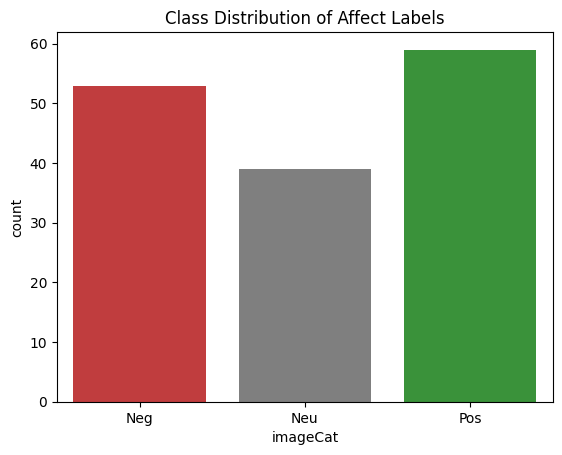

In [47]:
# Affect distribution 
ax = sns.countplot(x="imageCat", data=df_pyafar, palette=custom_palette_string)
ax.set_xticklabels([affect_map[label] for label in sorted(df_pyafar["imageCat"].unique())])
plt.title("Class Distribution of Affect Labels")
plt.show();

Slightly unbalanced..

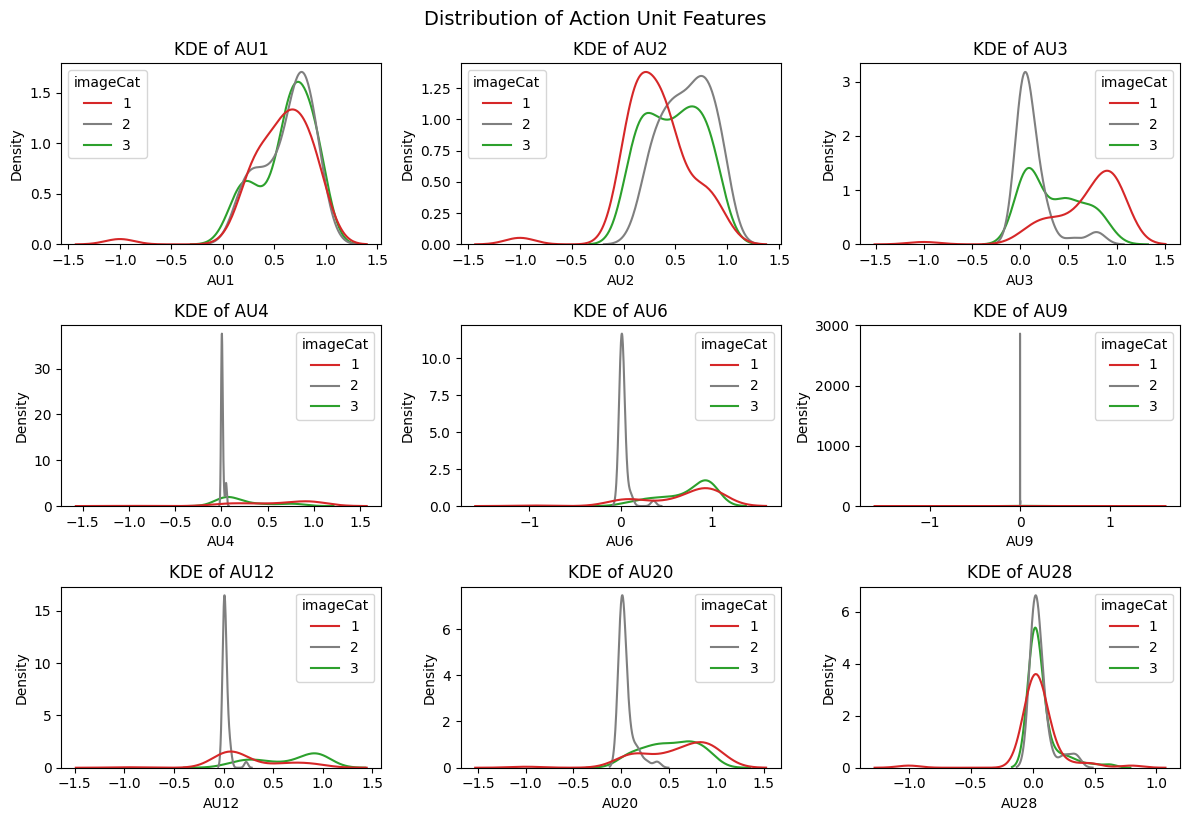

In [48]:
# Distribution of features (AU)

# List of action units
au_columns = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20', 'AU28']

# Set up the figure with multiple subplots (one for each AU)
plt.figure(figsize=(12, 8))

for i, au in enumerate(au_columns, 1):
    plt.subplot(3, 3, i)  # Arrange the plots in a 3x3 grid
    sns.kdeplot(data=df_pyafar, x=au, hue="imageCat", fill=False, common_norm=False, palette=custom_palette)
    plt.title(f"KDE of {au}")
    plt.xlabel(f"{au}")
    plt.ylabel("Density")

# Adjust layout and display the plots
plt.tight_layout()
plt.suptitle("Distribution of Action Unit Features", fontsize=14, y=1.02)
plt.show()

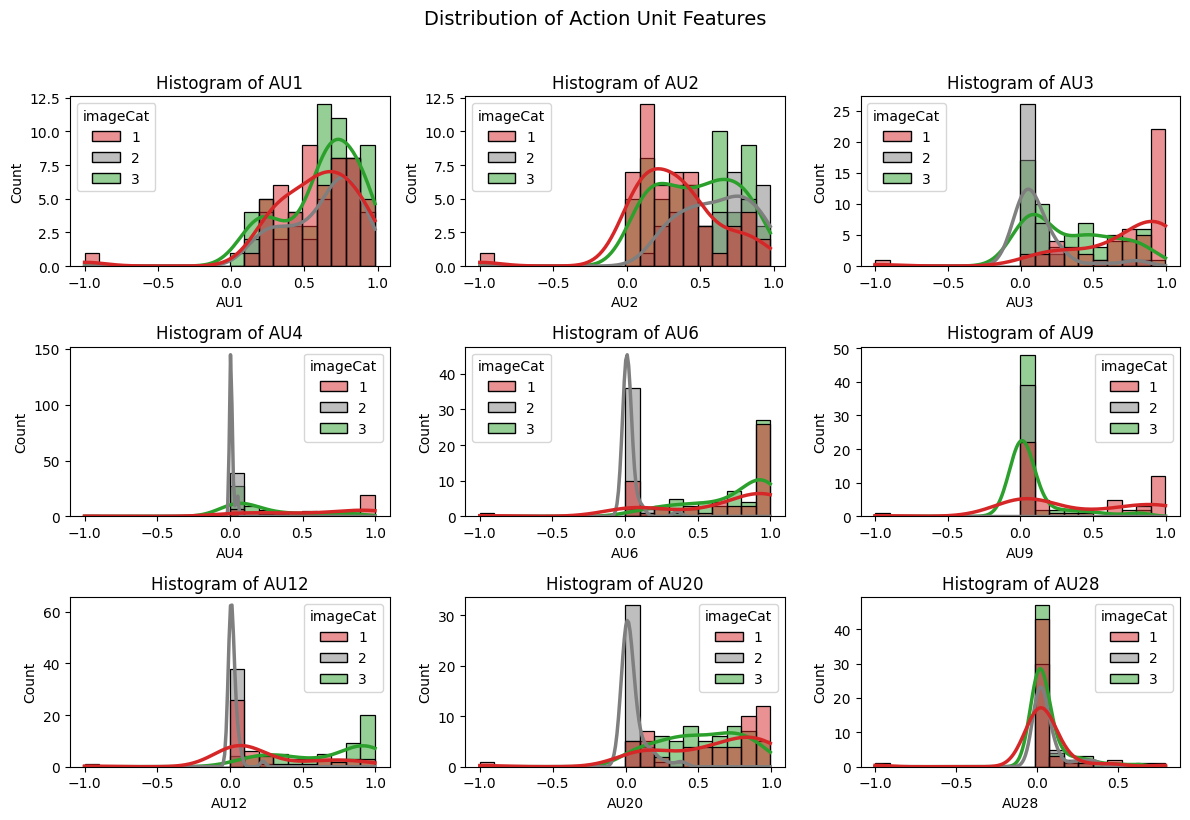

In [75]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle("Distribution of Action Unit Features", fontsize=14, y=1.02)

for i, au in enumerate(au_columns):
    row, col = divmod(i, 3)
    sns.histplot(data=df_pyafar, x=au, hue="imageCat", kde=True, bins=20, palette=custom_palette,ax=axes[row, col])
    axes[row, col].set_title(f"Histogram of {au}")

    for line in axes[row, col].lines:
        line.set_linewidth(2.5)

plt.tight_layout()
plt.show()


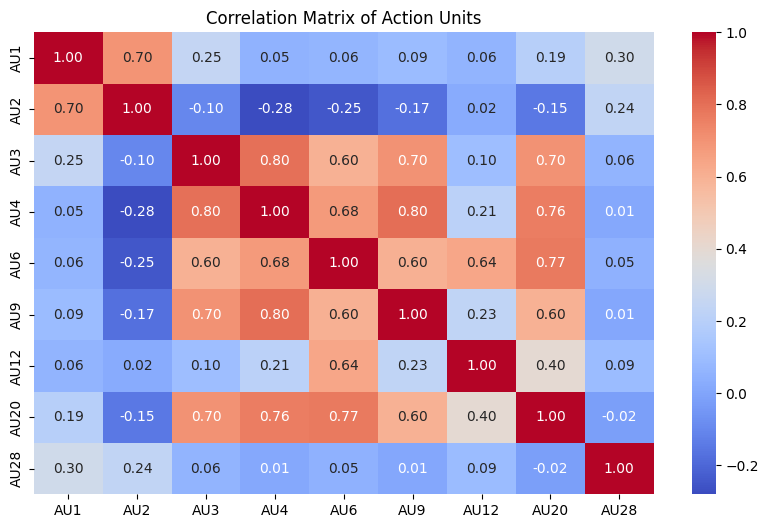

In [18]:
# Feature correlation

plt.figure(figsize=(10, 6))
sns.heatmap(df_pyafar.iloc[:, 2:-1].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Action Units")
plt.show()


QUESTION: 

- Max of 0.80... is it high correlation?

In [ ]:
# Boxplot AU vs affect

# plt.figure(figsize=(12, 6))
# for i, col in enumerate(df_pyafar.columns[2:-1], 1):
#     plt.subplot(3, 3, i)
#     sns.boxplot(x="imageCat", y=col, data=df_pyafar, palette="Set3")
#     plt.title(f"{col} vs Affect Category")
# plt.tight_layout()
# plt.show()


In [55]:
# Correlations AU/affect

# Affect into binary label 
df_pyafar['Pos_label'] = (df_pyafar['imageCat'] == 3).astype(int)
df_pyafar['Neu_label'] = (df_pyafar['imageCat'] == 2).astype(int)
df_pyafar['Neg_label'] = (df_pyafar['imageCat'] == 1).astype(int)

correlations = {}
for au in au_columns:
    pos_corr, _ = stats.pointbiserialr(df_pyafar[au], df_pyafar['Pos_label'])
    neu_corr, _ = stats.pointbiserialr(df_pyafar[au], df_pyafar['Neu_label'])
    neg_corr, _ = stats.pointbiserialr(df_pyafar[au], df_pyafar['Neg_label'])
    
    correlations[au] = {'Pos': pos_corr,'Neu': neu_corr, 'Neg': neg_corr}

corr_df = pd.DataFrame(correlations).T
corr_df

,Pos,Neu,Neg
AU1,0.050450,0.040363,-0.088588
AU2,0.054905,0.297901,-0.329317
AU3,-0.127219,-0.445249,0.538366
AU4,-0.128615,-0.457473,0.551004
AU6,0.391003,-0.677298,0.221399
AU9,-0.191720,-0.296828,0.468195
AU12,0.620963,-0.490126,-0.185329
AU20,0.228016,-0.595446,0.312955
AU28,0.060727,0.000459,-0.062500


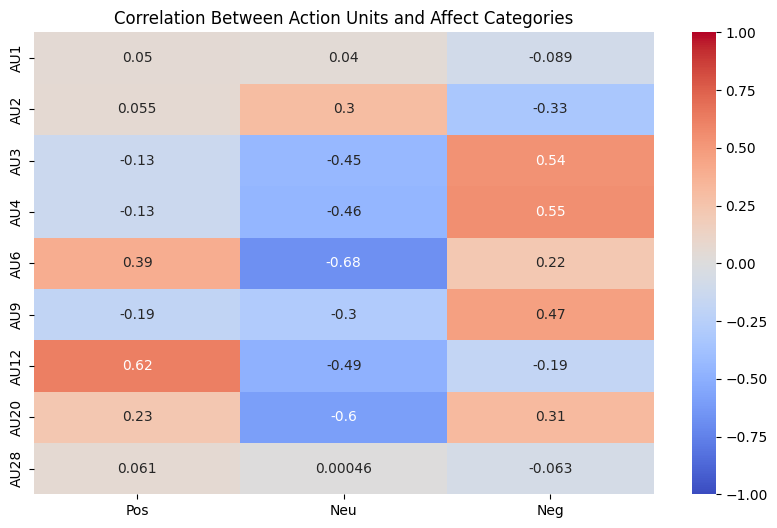

In [57]:
# Visualize correlations with heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Correlation Between Action Units and Affect Categories")
plt.show()

QUESTION: PCA

- Reduce correlation between features
- Small dataset for 9 features

- BUT.. no more interpretability, very important!!



.....should we try?


#### Train-test split

In [66]:
X = df_pyafar[['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20', 'AU28']]
y = df_pyafar['imageCat']  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(len(X_train))
print(len(X_dev))
print(len(X_test))

105
23
23


## SVM 

In [67]:
# Standardize features
scaler = StandardScaler()

# Define SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', svm_model)
])

# Hyperparameter tuning (Grid Search)
param_grid = {
    'svm__C': [0.1, 1, 10],  
    'svm__gamma': ['scale', 0.01, 0.1, 1]  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train with best
best_svm = grid_search.best_estimator_

In [69]:
# Evaluate

y_dev_pred = best_svm.predict(X_dev)
print('Validation Set')
print(classification_report(y_dev, y_dev_pred))

# Evaluate on Test Set
y_test_pred = best_svm.predict(X_test)
print('Test set')
print(classification_report(y_test, y_test_pred))


Validation Set
              precision    recall  f1-score   support

           1       0.75      0.75      0.75         8
           2       0.67      1.00      0.80         6
           3       1.00      0.67      0.80         9

    accuracy                           0.78        23
   macro avg       0.81      0.81      0.78        23
weighted avg       0.83      0.78      0.78        23

Test set
              precision    recall  f1-score   support

           1       0.78      0.88      0.82         8
           2       0.86      1.00      0.92         6
           3       1.00      0.78      0.88         9

    accuracy                           0.87        23
   macro avg       0.88      0.88      0.87        23
weighted avg       0.89      0.87      0.87        23



### XGBoost

In [71]:
# Convert dataset into DMatrix (XGBoost's optimized format)
dtrain = xgb.DMatrix(X_train, label=y_train)
ddev = xgb.DMatrix(X_dev, label=y_dev)
dtest = xgb.DMatrix(X_test, label=y_test)

In [74]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False)

param_grid = {
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'n_estimators': [50, 100, 200], 
    'subsample': [0.7, 1.0], 
    'colsample_bytree': [0.7, 1.0],  
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fix labels for xgb..
y_train_fixed = y_train - 1
y_dev_fixed = y_dev - 1
y_test_fixed = y_test - 1

grid_search.fit(X_train, y_train_fixed)

# Train
best_xgb = grid_search.best_estimator_


/Users/florentinafabregas/anaconda3/envs/pyafar/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/florentinafabregas/anaconda3/envs/pyafar/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/florentinafabregas/anaconda3/envs/pyafar/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/florentinafabregas/anaconda3/envs/pyafar/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740:

In [77]:
# Evaluate 

y_dev_pred_xgb = best_xgb.predict(X_dev)
print('Validation Set')
print(classification_report(y_dev_fixed, y_dev_pred_xgb))

# Evaluate on Test Set
y_test_pred_xgb = best_xgb.predict(X_test)
print('Test set')
print(classification_report(y_test_fixed, y_test_pred_xgb))



Validation Set
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.67      0.67      0.67         6
           2       0.78      0.78      0.78         9

    accuracy                           0.74        23
   macro avg       0.73      0.73      0.73        23
weighted avg       0.74      0.74      0.74        23

Test set
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.83      0.83      0.83         6
           2       0.80      0.89      0.84         9

    accuracy                           0.83        23
   macro avg       0.83      0.82      0.83        23
weighted avg       0.83      0.83      0.83        23



In [78]:
from feat import Detector